# New York City Taxi Fare Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-whitegrid')

In [2]:
df_train =  pd.read_csv(r'C:\Users\johnl\Documents\new-york-city-taxi-fare-pred\train.csv', nrows = 500_000, parse_dates=["pickup_datetime"])

# list first few rows (datapoints)
df_train.shape

(500000, 8)

In [3]:
df_test =  pd.read_csv(r'C:\Users\johnl\Documents\new-york-city-taxi-fare-pred\test.csv')

# list first few rows (datapoints)
df_test.shape

(9914, 7)

### Check statistic for each feature

In [4]:
df_train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


**Takeways**
- The min fare amount is a negative, so unless in NYC they pay you for taking a taxi all negative fares should be removed
- We have min passanger count of 0, are they transporting goods perhaps? Need to decide do we keep these rows or not

Latitude and longitude are a pair of numbers (coordinates) used to describe a position on the plane of a geographic coordinate system. The numbers are in decimal degrees format and range from -90 to 90 for latitude and -180 to 180 for longitude.
- Thus we have coordinates that dont exist and need to be removed
- Also note even if coordinates are actual coordinates we need to check that these coodinates are actually in NYC , so we will need to define cut offs for what we consider to be within our bounds of NYC

In [5]:
df_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


### Remove negative fares
This step is simple and requires the least effort

In [6]:

df_train = df_train[df_train.fare_amount>=0]

### Plot of Fare 

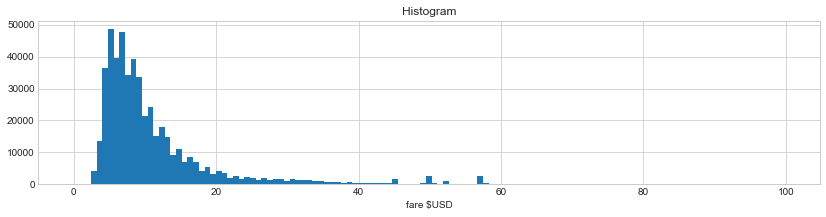

In [7]:

df_train[df_train.fare_amount<100].fare_amount.hist(bins=125, figsize=(14,3))
plt.xlabel('fare $USD')
plt.title('Histogram');

- Vast majority of fares are cheap quick fares (prices less than 20 USD)<br>
The histogram seems to level out past this point besides several spikes between 40 USD and 60 USD, this is probably due to flat fares, for example its a flat charge of 52 USD from JFK airport to Manhattan

## Missing Data

In [8]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64


We have very few missing data so its probably easier to just drop these rows than to try impute values for them 

In [9]:
df_train = df_train.dropna(how = 'any', axis = 'rows')

In [10]:
print(df_train.isnull().sum())

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


## Dealing with Longitude and Latitude 

So we need to determine our boundaries for NYC, the most effective way to do this would probably be to drop a "box" over NYC and if the pickup/drop off coordinates fall within this space we include them <br>
The center coordinates of NYC are 40° 42' 43" N / 74° 0' 21" W <br>
Looking at our test set the coordinates seem to be more than reasonable, we could possibly use the min/ max for both longitude and latitude from the test set as our boundaries as this way we wont be changing our test data or excluding anything from it but this gives us a good outline for our boundary 

In [11]:
# minimum and maximum longitude test set
min_long =min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min())
max_long = max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())
# minimum and maximum latitude test
min_lat = min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min())
max_lat = max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

In [12]:
print(min_long,max_long,min_lat, max_lat)

-74.263242 -72.986532 40.568973 41.709555


### Boundary Function

In [13]:
# this gets around verification error when using imread on http// link (do more research)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [14]:

# this function will also be used with the test set below
def boundary(df, boundary_shape):
    return (df.pickup_longitude >= boundary_shape[0]) & (df.pickup_longitude <= boundary_shape[1]) & \
           (df.pickup_latitude >= boundary_shape[2]) & (df.pickup_latitude <= boundary_shape[3]) & \
           (df.dropoff_longitude >= boundary_shape[0]) & (df.dropoff_longitude <= boundary_shape[1]) & \
           (df.dropoff_latitude >= boundary_shape[2]) & (df.dropoff_latitude <= boundary_shape[3])
            
# load image of NYC map
boundary_shape = (min_long,max_long,min_lat, max_lat)
boundary_long = (min_long,max_long)
boundary_lat =  (min_lat, max_lat)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')


In [15]:
df_train = df_train[boundary(df_train, boundary_shape)]

In [16]:
print(df_train.describe())

         fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  489367.000000     489367.000000    489367.000000      489367.000000   
mean       11.331529        -73.975093        40.751077         -73.974104   
std         9.756526          0.038382         0.029470           0.037652   
min         0.000000        -74.262970        40.569414         -74.255235   
25%         6.000000        -73.992258        40.736567         -73.991562   
50%         8.500000        -73.982077        40.753395         -73.980575   
75%        12.500000        -73.968333        40.767489         -73.965262   
max       500.000000        -73.085745        41.650000         -73.085764   

       dropoff_latitude  passenger_count  
count     489367.000000    489367.000000  
mean          40.751472         1.683928  
std            0.032592         1.307572  
min           40.569414         0.000000  
25%           40.735630         1.000000  
50%           40.753892         1.00000

In [17]:
def plot_on_map(df, boundary_shape, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    # this line will generate our scatter plot on a normal plot
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    # sets limits
    axs[0].set_xlim((boundary_shape[0], boundary_shape[1]))
    axs[0].set_ylim((boundary_shape[2], boundary_shape[3]))
    axs[0].set_title('Pickup locations')
    #imshow overlays our image on the graph
    #The Zorder attribute of the Matplotlib Module helps us to improve the overall representation of our plot
    #This property determines how close the points or plot is to the observer. 
    #The higher the value of Zorder closer the plot or points to the viewer.
    # Extent defines the left and right limits, and the bottom and top limits.
    # It takes four values like so: extent=[horizontal_min,horizontal_max,vertical_min,vertical_max].
    axs[0].imshow(nyc_map, zorder=0, extent=boundary_shape)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((boundary_shape[0], boundary_shape[1]))
    axs[1].set_ylim((boundary_shape[2], boundary_shape[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=boundary_shape)

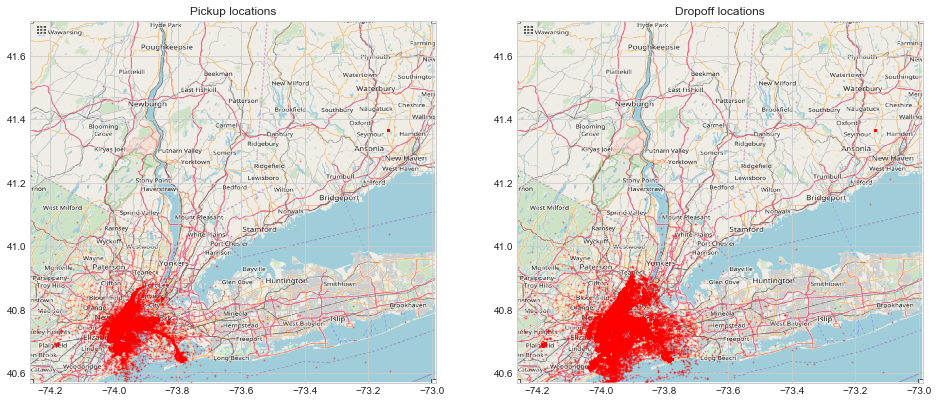

In [18]:
plot_on_map(df_train, boundary_shape, nyc_map, s=1, alpha=0.3)

We have coordinates within our boundary that are in the water and unless taxi cabs are amphibious in NYC we will need to deal with them

### cool visualization 

https://www.kaggle.com/drgilermo/dynamics-of-new-york-city-animation

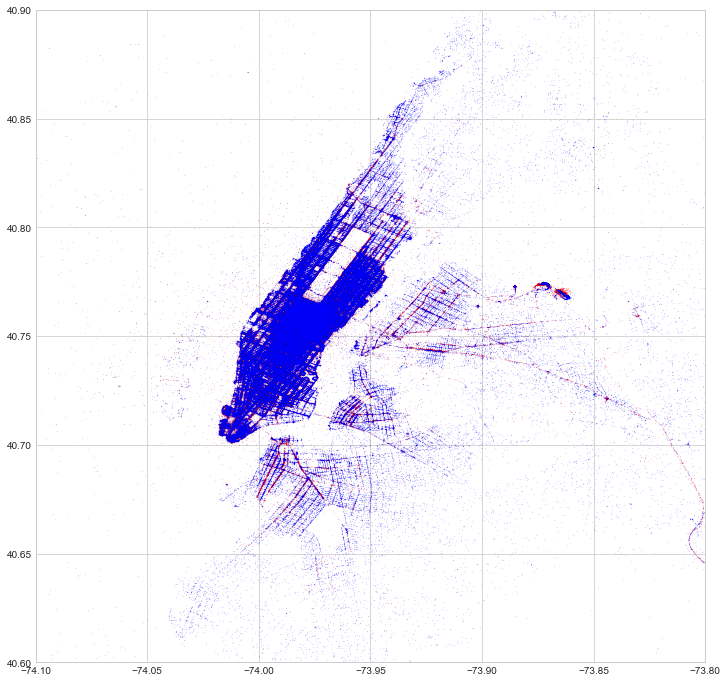

In [19]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = boundary(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)
    ax.set_ylim((40.6, 40.9))
    ax.set_xlim((-74.1, -73.8))
plot_hires(df_train, boundary_shape)

We can make out the streets

## Effects of Features on Fare Price
We can create new features that will be important in predicting the fare price <br>

**Potential Features** <br>
Distance travelled <br>
Number of passangers (do they have add ons for added passangers) <br>
Day of fare (do weekends have a higher rate) <br>
Time of fare (is there a higher rate for rush hour or is there a higher night time rate) <br>

### Distance travelled feature

In [20]:
pip install mpu --user

Note: you may need to restart the kernel to use updated packages.


In [21]:
import mpu
# Point one
lat1 = 52.2296756
lon1 = 21.0122287

# Point two
lat2 = 52.406374
lon2 = 16.9251681

# What you were looking for
dist = mpu.haversine_distance((lat1, lon1), (lat2, lon2))
print(dist)  # gives 278.45817507541943.


278.45817507541943


In [22]:
def haversine_vectorize(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    newlon = lon2 - lon1
    newlat = lat2 - lat1

    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2

    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist 
    return km

Text(0.5, 1.0, 'Histogram ride distances in km')

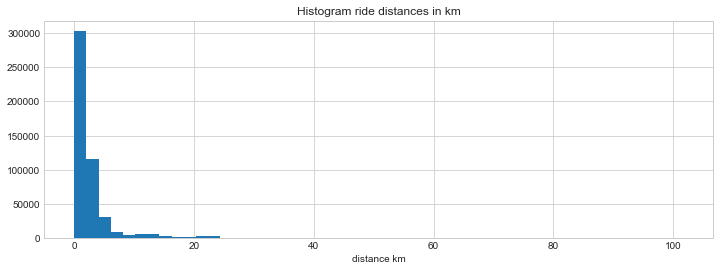

In [23]:
df_train['distance_km'] = haversine_vectorize(df_train.pickup_latitude, df_train.pickup_longitude, \
                                      df_train.dropoff_latitude, df_train.dropoff_longitude)

df_train.distance_km.hist(bins=50, figsize=(12,4))
plt.xlabel('distance km')
plt.title('Histogram ride distances in km')


Majority of fares are between 0-10 km so we can assume the overall fare price will be lower

### Passanger count and fare price

In [24]:
df_train.groupby('passenger_count')['fare_amount'].mean()

passenger_count
0     8.942446
1    11.202274
2    11.810555
3    11.469115
4    11.731875
5    11.206488
6    12.339507
Name: fare_amount, dtype: float64

Besides the 0 passanger trips the fare amount seems to be rather similar which would suggest there is no additional add ons for extra passangers

In [25]:
df_train.groupby('passenger_count')['distance_km','fare_amount'].mean()

C:\Users\johnl\Anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,distance_km,fare_amount
passenger_count,,
0,2.147423,8.942446
1,2.663322,11.202274
2,2.884422,11.810555
3,2.700039,11.469115
4,2.775416,11.731875
5,2.722261,11.206488
6,2.880948,12.339507


Again it seems fairly clear the passangers dont impact the fare drastically (unless there are no passangers)

### Price vs Distance
We would ass that the further we pay

Text(0.5, 1.0, 'All data')

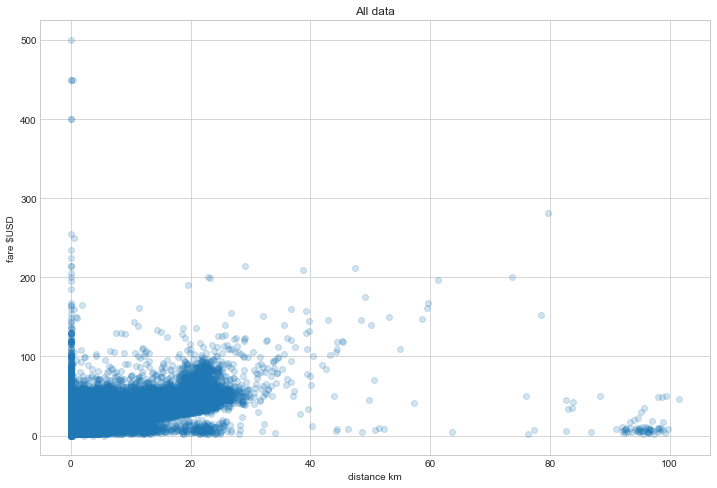

In [26]:
# scatter plot distance - fare
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax.scatter(df_train.distance_km, df_train.fare_amount, alpha=0.2)
ax.set_xlabel('distance km')
ax.set_ylabel('fare $USD')
ax.set_title('All data')


There appears to be a noticable amount of journeys with a distance of 0, perhaps these were round trips? <br>
A key issue with these 0km trips is we have no way of knowing if the car just sat idle or if it was a long round trip, we simply have the start and end location so these points dont really provide any useful data so we will drop them. <br>
We also have a cluster of fares near 100km that were almost free which wouldnt make much sense <br>
Overall the plot does seem to follow the idea of more distance more money

In [27]:
x = (df_train.distance_km>= 0.05)
df_train = df_train[x]

# Time

In [100]:
def time_features(df,time_col):
    df[time_col] = pd.to_datetime(df[time_col])
    df['day'] = pd.to_datetime(df[time_col]).dt.day
    df['dayofweek'] = pd.to_datetime(df[time_col]).dt.dayofweek
    df['week']=pd.to_datetime(df[time_col]).dt.isocalendar().week
    df['hour'] = pd.to_datetime(df[time_col]).dt.hour
    df['minute'] = pd.to_datetime(df[time_col]).dt.minute
    df['month'] = pd.to_datetime(df[time_col]).dt.month
    df['year'] =pd.to_datetime(df[time_col]).dt.year
    return df

In [101]:
df_train = time_features(df_train,'pickup_datetime')
df_train.head(5)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km,day,dayofweek,week,hour,minute,month,minute_bin,year
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.410184,15,0,25,17,26,6,3,2009
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,4.625598,5,1,1,16,52,1,6,2010
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,1.000393,18,3,33,0,35,8,4,2011
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,0.909868,21,5,16,4,30,4,4,2012
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.360166,9,1,10,7,51,3,6,2010


In [102]:
def min_bin(min):
    if min >= 50: return 6
    elif min >= 40: return 5
    elif min >= 30: return 4
    elif min >= 20: return 3
    elif min >= 10: return 2
    elif min >= 0: return 1

In [103]:
df_train['minute_bin'] = df_train.minute.apply(lambda x:min_bin(x))

## Plot of fare amounts per month

No handles with labels found to put in legend.


[Text(0, 0, 'Jan'),
 Text(0, 0, ',Feb'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'Aug'),
 Text(0, 0, 'Sep'),
 Text(0, 0, 'Oct'),
 Text(0, 0, 'Nov'),
 Text(0, 0, 'Dec')]

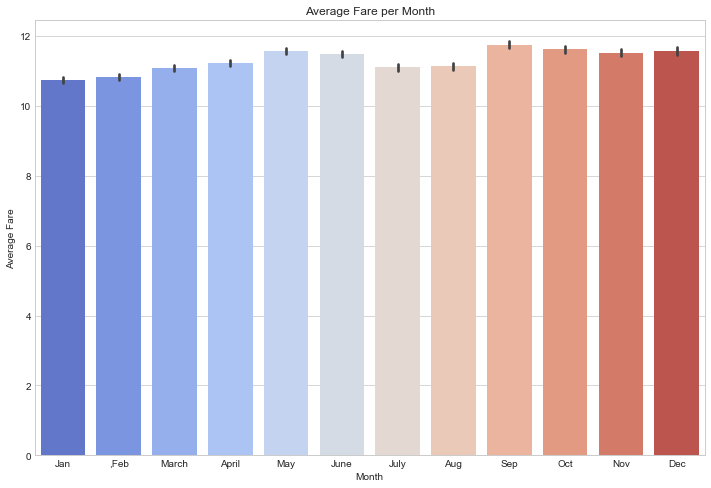

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax =sns.barplot(x = 'month', y = 'fare_amount', data = df_train, estimator = np.average, palette='coolwarm')
plt.ylabel('Average Fare')
plt.xlabel('Month')
plt.title("Average Fare per Month")
plt.legend()
ax.set_xticklabels(labels = ["Jan",",Feb","March","April", "May","June","July","Aug","Sep","Oct","Nov","Dec"])

The cost of fares seems consistent across the year

## Plot of Number of Fares per month

No handles with labels found to put in legend.


[Text(0, 0, 'Jan'),
 Text(0, 0, ',Feb'),
 Text(0, 0, 'March'),
 Text(0, 0, 'April'),
 Text(0, 0, 'May'),
 Text(0, 0, 'June'),
 Text(0, 0, 'July'),
 Text(0, 0, 'Aug'),
 Text(0, 0, 'Sep'),
 Text(0, 0, 'Oct'),
 Text(0, 0, 'Nov'),
 Text(0, 0, 'Dec')]

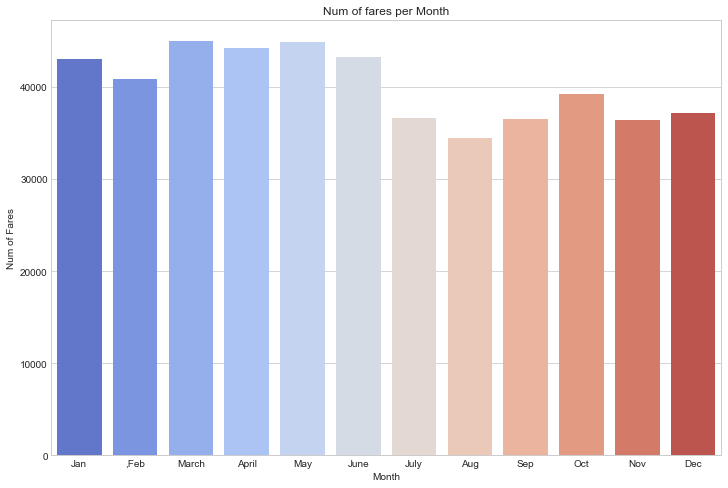

In [105]:

fig, ax = plt.subplots(1, 1, figsize=(12,8))
ax =sns.countplot(x = df_train["month"],palette='coolwarm')
plt.ylabel('Num of Fares')
plt.xlabel('Month')
plt.title("Num of fares per Month")
plt.legend()
ax.set_xticklabels(labels = ["Jan",",Feb","March","April", "May","June","July","Aug","Sep","Oct","Nov","Dec"])

Most fares are in the summer, perhaps due to the large amount of tourists

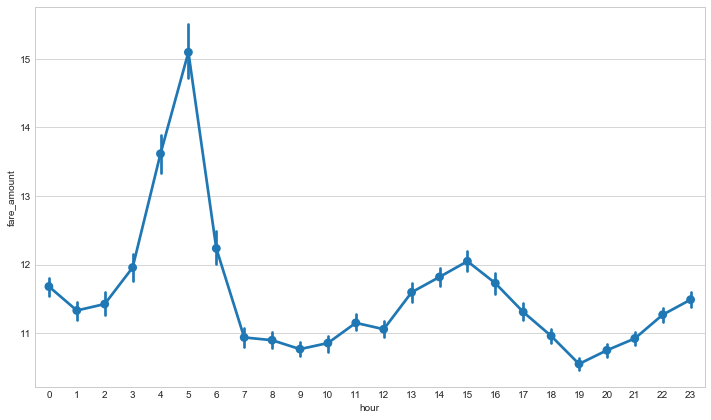

In [34]:
fig, axes = plt.subplots(figsize = (12,7))
sns.pointplot(x = 'hour', y = 'fare_amount', data = df_train, estimator = np.average)

Drastic increase in average fare amount in the early hours of night, we also see the trend increase upwards past 19:00 so its clear that fares are most expensive at night

# Model

In [106]:
X = df_train.drop(['fare_amount',"key","pickup_datetime","week"],axis=1)
y = df_train.fare_amount

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [69]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((385340, 12), (96335, 12), (385340,), (96335,))

### Linear Regression Model

In [70]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)
y_pred = reg.predict(X_test)
print('Linear regression, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

Linear regression, Root mean square is:  5.291486536304116


### Decision Tree Model

In [40]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor().fit(X_train, y_train)
reg.score(X_train, y_train)
y_pred = reg.predict(X_test)
print('DecisionTreeRegressor, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

C:\Users\johnl\Anaconda\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


DecisionTreeRegressor, Root mean square is:  5.225188365218655


### LGBM Model

In [93]:
import lightgbm as lgb
lgbm = lgb.LGBMRegressor().fit(X_train.values, y_train.values)
lgbm.score(X_train.values, y_train.values)
y_pred_LGBM = lgbm.predict(X_test.values)
print('LGBM, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred_LGBM)))

LGBM, Root mean square is:  3.660572275157882


### XGB Model

In [84]:
from xgboost import XGBRegressor

In [95]:
XGB_model = XGBRegressor(learning_rate=0.3, max_depth=6, n_estimators=500)
XGB_model.fit(X_train.values, y_train.values)
XGB_model.score(X_train.values, y_train.values)
y_pred_XGB = XGB_model.predict(X_test.values)
print('XGB, Root mean square is: ',np.sqrt(mean_squared_error(y_test,y_pred)))

C:\Users\johnl\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\johnl\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


XGB, Root mean square is:  3.5135007285121365


### Emsembled LGBM/XGB Model

In [97]:
# ensembled prediction over splitted test data
ensembled_prediction = (0.5*(y_pred_XGB))+(0.5*(y_pred_LGBM))

print('Ensembled Root mean square is: ',np.sqrt(mean_squared_error(y_test,ensembled_prediction)))


Ensembled Root mean square is:  3.4791227921855254


##  Prep test dataframe for Prediction

In [124]:
df_test['distance_km'] = haversine_vectorize(df_test.pickup_latitude, df_test.pickup_longitude, \
                                      df_test.dropoff_latitude, df_test.dropoff_longitude)
df_test = time_features(df_test,'pickup_datetime')

test_df = df_test.drop(["key","pickup_datetime","week"],axis=1)

In [125]:
print(len(test_df.columns))

12


In [129]:
XTEST =  test_df.values
XTEST

array([[-7.39733200e+01,  4.07638054e+01, -7.39814301e+01, ...,
         8.00000000e+00,  1.00000000e+00,  2.01500000e+03],
       [-7.39868622e+01,  4.07193832e+01, -7.39988861e+01, ...,
         8.00000000e+00,  1.00000000e+00,  2.01500000e+03],
       [-7.39825240e+01,  4.07512600e+01, -7.39796540e+01, ...,
         5.30000000e+01,  1.00000000e+01,  2.01100000e+03],
       ...,
       [-7.39916000e+01,  4.07266083e+01, -7.37897415e+01, ...,
         4.40000000e+01,  4.00000000e+00,  2.01500000e+03],
       [-7.39855728e+01,  4.07354317e+01, -7.39391785e+01, ...,
         5.00000000e+00,  1.00000000e+00,  2.01500000e+03],
       [-7.39880219e+01,  4.07540703e+01, -7.40002823e+01, ...,
         6.00000000e+00,  1.00000000e+00,  2.01500000e+03]])

In [131]:
y_XGB_predict = XGB_model.predict(XTEST)


C:\Users\johnl\Anaconda\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


In [132]:
y_LGBM_predict = lgbm.predict(XTEST)

In [135]:
ensembled_prediction = (0.5*y_XGB_predict)+(0.5*y_LGBM_predict)

In [136]:
submission = pd.DataFrame(
    {'key': df_test.key, 'fare_amount': ensembled_prediction},
    columns = ['key', 'fare_amount'])

## Submission

In [139]:
ensembled_prediction = (0.5*y_XGB_predict)+(0.5*y_LGBM_predict)
submission.to_csv(r"C:\Users\johnl\Documents\new-york-city-taxi-fare-pred\sub.csv",index = False)

submission.head(10)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.054387
1,2015-01-27 13:08:24.0000003,8.895347
2,2011-10-08 11:53:44.0000002,5.386872
3,2012-12-01 21:12:12.0000002,8.618161
4,2012-12-01 21:12:12.0000003,15.547404
5,2012-12-01 21:12:12.0000005,9.730555
6,2011-10-06 12:10:20.0000001,6.253932
7,2011-10-06 12:10:20.0000003,53.327017
8,2011-10-06 12:10:20.0000002,13.445816
9,2014-02-18 15:22:20.0000002,7.418754


**Test Score** - 3.8

#### To-do
Improve feature selection